#ARIMA Model Forecasting with Walk-Forward Validation

#Objective:

To demonstrate how to build and evaluate an ARIMA model using walk-forward validation for time series forecasting on synthetic financial data.

#1. Setup and Library Imports

In [6]:
import pandas as pd # Import the pandas library, commonly used for data manipulation and analysis, especially with DataFrames and Series.
import numpy as np  # Import the numpy library, essential for numerical operations, especially with arrays.
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module, used for creating static, interactive, and animated visualizations in Python.
from statsmodels.tsa.arima.model import ARIMA # Import the ARIMA model from the statsmodels library, which is a powerful tool for time series analysis and forecasting.
from sklearn.metrics import mean_squared_error # Import mean_squared_error from scikit-learn, a common metric to evaluate the performance of regression models.
from math import sqrt # Import the sqrt function from the math module, used to calculate the square root (e.g., for RMSE).
import warnings # Import the warnings module, which allows you to control how Python handles warning messages.

# Ignore warnings for cleaner output, especially from statsmodels
warnings.filterwarnings("ignore") # This line configures the warnings module to ignore all warning messages. This is often done in notebooks to prevent verbose output from libraries like statsmodels during repetitive operations or when certain warnings are expected and not critical to the immediate output.

#2. Generate Synthetic Financial Data
We'll create a synthetic time series that mimics some characteristics of financial data, like a general trend and some volatility.

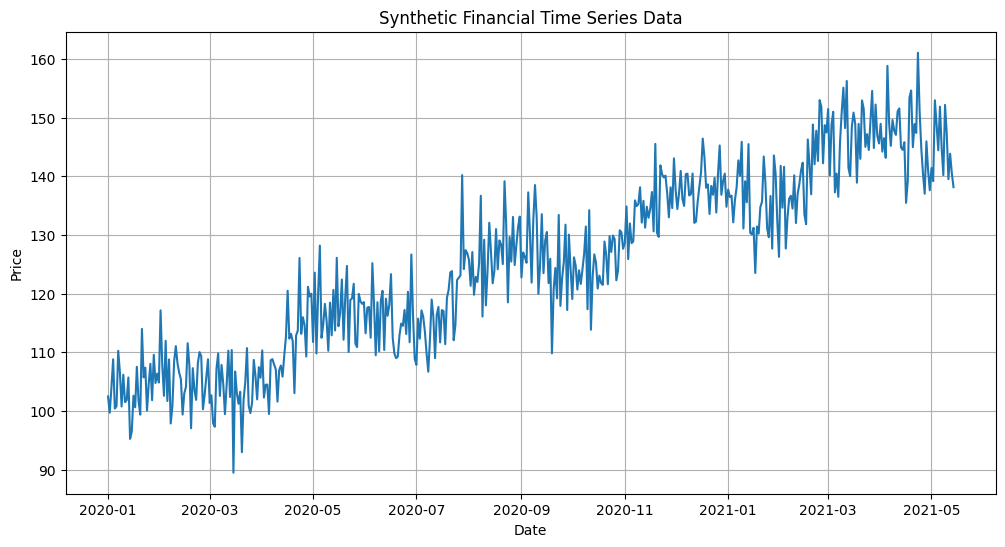

Generated synthetic data of shape: (500,)
2020-01-01    102.483571
2020-01-02     99.709299
2020-01-03    104.038598
2020-01-04    108.812673
2020-01-05    100.420884
Freq: D, dtype: float64


In [7]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of data points
n_points = 500

# Generate a base price with a trend
base_price = np.linspace(100, 150, n_points)

# Add some random noise (daily fluctuations)
noise = np.random.normal(0, 1, n_points) * 5

# Add some seasonality (e.g., weekly or monthly cycles, simplified here)
# For simplicity, let's add a subtle sine wave pattern
seasonality = 5 * np.sin(np.linspace(0, 30, n_points))

# Combine to form the synthetic financial data
data = base_price + noise + seasonality

# Create a pandas Series with a date index
dates = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
series = pd.Series(data, index=dates)

# Plot the synthetic data to visualize it
plt.figure(figsize=(12, 6))
plt.plot(series)
plt.title('Synthetic Financial Time Series Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

print(f"Generated synthetic data of shape: {series.shape}")
print(series.head())

#3. Determine ARIMA Orders (p, d, q)
Before fitting an ARIMA model, we need to determine the order of the AR (p), I (d), and MA (q) components.

p (AutoRegressive): Number of lag observations included in the model.

d (Integrated): Number of times the raw observations are differenced.

q (Moving Average): Size of the moving average window.


ADF Test on original series:
ADF Statistic: -0.959031
p-value: 0.767912
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
Series is likely non-stationary (fail to reject H0)

ADF Test on differenced series (d=1):
ADF Statistic: -10.749441
p-value: 0.000000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
Series is likely stationary (reject H0)


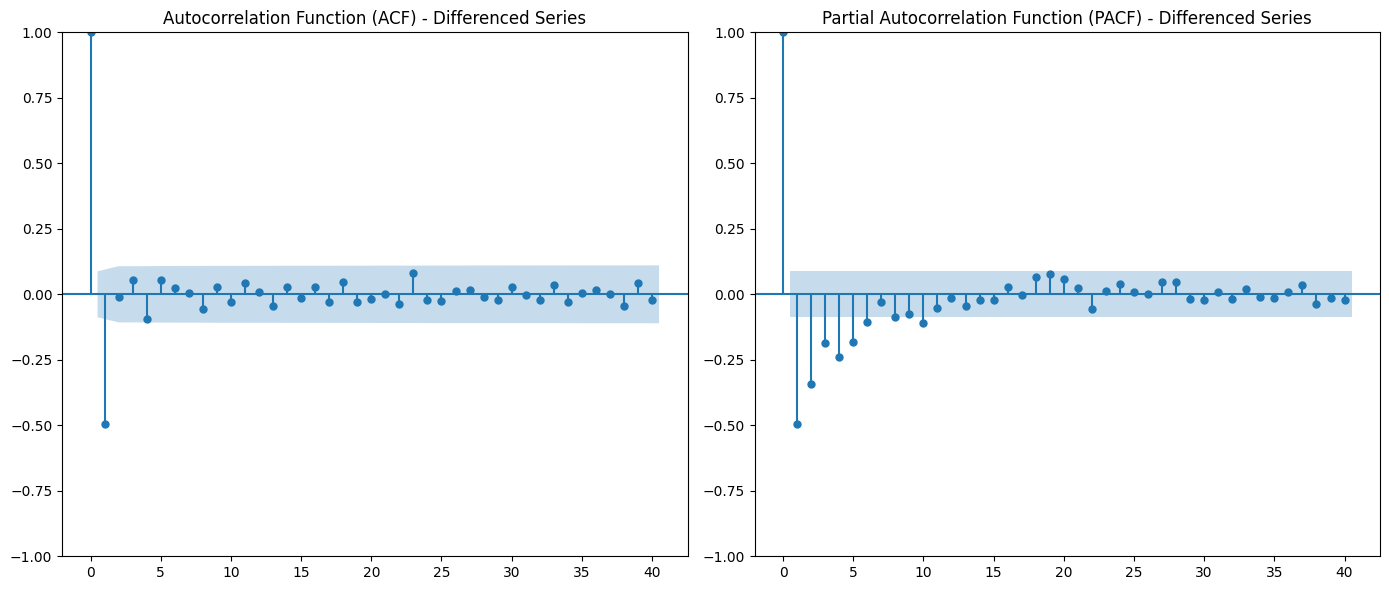


Chosen ARIMA Order (p, d, q): (1, 1, 1)


In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Import functions to plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) which are crucial for identifying ARIMA orders.
from statsmodels.tsa.stattools import adfuller # Import the Augmented Dickey-Fuller (ADF) test, a statistical test to check for stationarity in a time series.

# 3.1. Check for Stationarity (ADF Test)
# ARIMA models assume stationarity. If the series is not stationary, we need to difference it (determine 'd').
# Stationarity means that the statistical properties of the time series (mean, variance, autocorrelation) do not change over time.
# The 'd' parameter in ARIMA represents the number of times the raw observations are differenced to make the series stationary.

def adf_test(series):
    """
    Performs the Augmented Dickey-Fuller test on a given time series
    to check for stationarity and prints the results.
    """
    result = adfuller(series, autolag='AIC') # Perform the ADF test. 'autolag=AIC' automatically selects the optimal number of lags for the test based on the Akaike Information Criterion.
    print('ADF Statistic: %f' % result[0]) # The test statistic. A more negative value suggests stronger rejection of the null hypothesis (i.e., more stationary).
    print('p-value: %f' % result[1])       # The p-value. A small p-value (typically <= 0.05) indicates that the series is stationary.
    print('Critical Values:')              # Critical values at different significance levels. If the ADF statistic is less than a critical value, we reject the null hypothesis at that level.
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] <= 0.05: # Check if the p-value is less than or equal to 0.05 (a common significance level).
        print("Series is likely stationary (reject H0)") # If p-value <= 0.05, we reject the null hypothesis (H0: series is non-stationary) and conclude it's likely stationary.
    else:
        print("Series is likely non-stationary (fail to reject H0)") # If p-value > 0.05, we fail to reject the null hypothesis, suggesting the series is non-stationary.

print("\nADF Test on original series:")
adf_test(series) # Apply the ADF test to the raw, original time series.

# If non-stationary, apply differencing and re-test
# Let's assume for this practical, a first-order differencing might be needed due to the trend.
# We'll difference it and re-evaluate, but for a real-world scenario, you might iterate.
differenced_series = series.diff().dropna() # Apply first-order differencing. .diff() calculates the difference between consecutive observations. .dropna() removes the first NaN value resulting from differencing.

print("\nADF Test on differenced series (d=1):")
adf_test(differenced_series) # Apply the ADF test again to the differenced series to check if it has become stationary.

# 3.2. Plot ACF and PACF for the differenced series (to determine p and q)
# These plots help us visually identify the optimal 'p' and 'q' parameters for the ARIMA model.
# 'p' (AR order) is often indicated by the lag where PACF cuts off.
# 'q' (MA order) is often indicated by the lag where ACF cuts off.

plt.figure(figsize=(14, 6)) # Create a new figure with a specified size for the plots.

plt.subplot(121) # Create a subplot grid of 1 row, 2 columns, and select the first subplot.
plot_acf(differenced_series, ax=plt.gca(), lags=40) # Plot the Autocorrelation Function (ACF) for the differenced series.
                                                # 'ax=plt.gca()' uses the current axes. 'lags=40' shows autocorrelations up to 40 lags.
plt.title('Autocorrelation Function (ACF) - Differenced Series') # Set the title for the ACF plot.

plt.subplot(122) # Select the second subplot in the 1x2 grid.
plot_pacf(differenced_series, ax=plt.gca(), lags=40, method='ywm') # Plot the Partial Autocorrelation Function (PACF) for the differenced series.
                                                                # 'method='ywm'' specifies the Yule-Walker method, a common estimation method for PACF.
plt.title('Partial Autocorrelation Function (PACF) - Differenced Series') # Set the title for the PACF plot.

plt.tight_layout() # Adjusts subplot parameters for a tight layout, preventing labels from overlapping.
plt.show() # Display the plots.

# Based on visual inspection:
# - ACF: Significant spikes at lag 1, then quickly decays. Suggests q=1 or 2.
# - PACF: Significant spike at lag 1, then quickly decays. Suggests p=1 or 2.
# Interpretation of ACF and PACF plots is often an art as much as a science.
# For simplicity, let's start with (1,1,1) as a common initial guess, or (2,1,1) or (1,1,2).
# (1,1,1) indicates an AR(1) component, 1 differencing step, and an MA(1) component.
# We will use (1,1,1) for this example.
p, d, q = 1, 1, 1 # Example ARIMA order (p, d, q). These are the parameters for the ARIMA model.
print(f"\nChosen ARIMA Order (p, d, q): ({p}, {d}, {q})") # Print the chosen ARIMA order for clarity.

#4. Walk-Forward Validation Implementation
Walk-forward validation is crucial for time series forecasting. Instead of a single train-test split, it simulates how a model would be used in production.

Total data points: 500
Initial training set size: 350
Test set size: 150

Starting Walk-Forward Validation...

Walk-Forward Validation Complete.
Final Test RMSE: 5.603


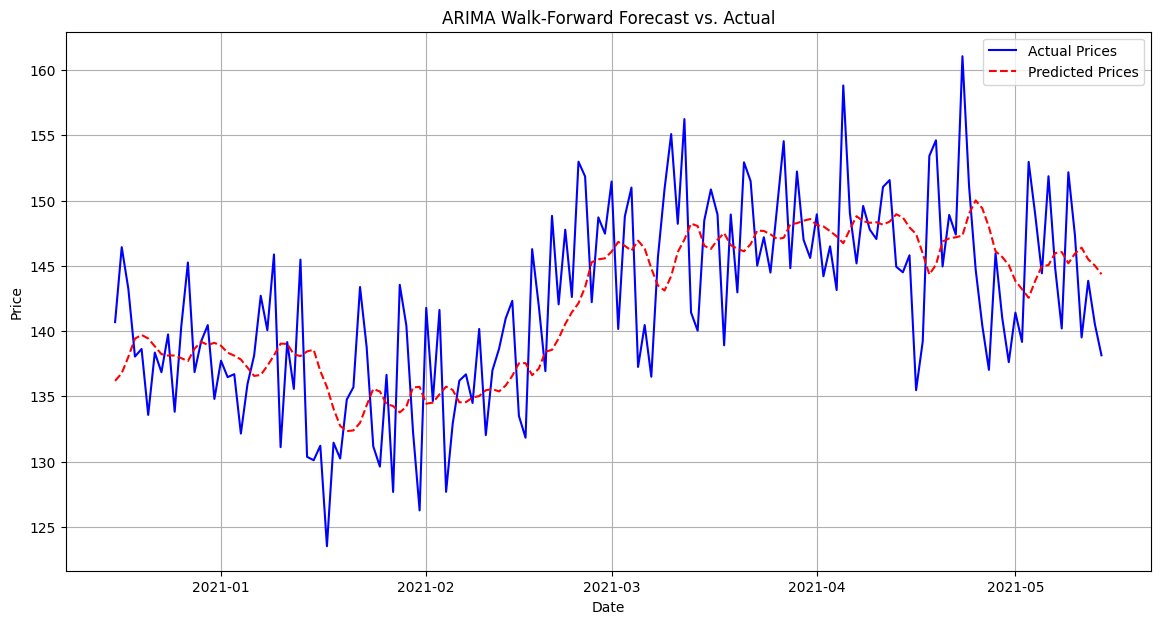

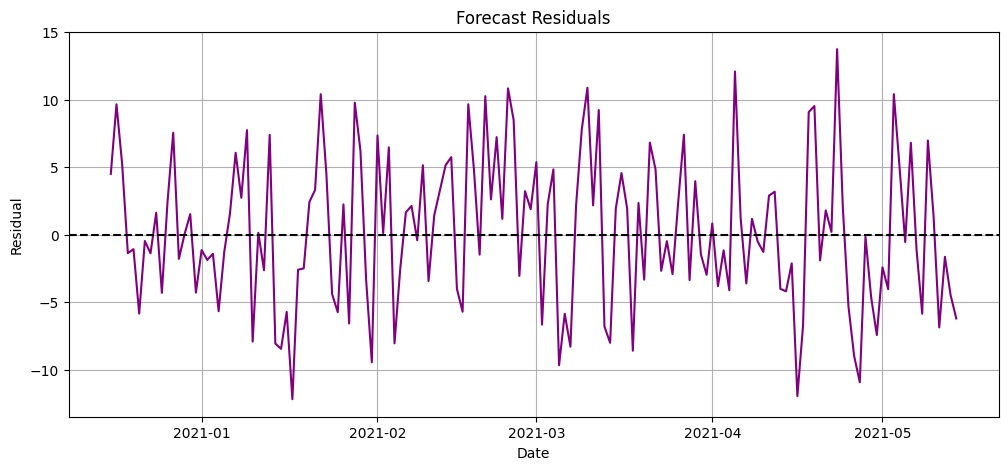

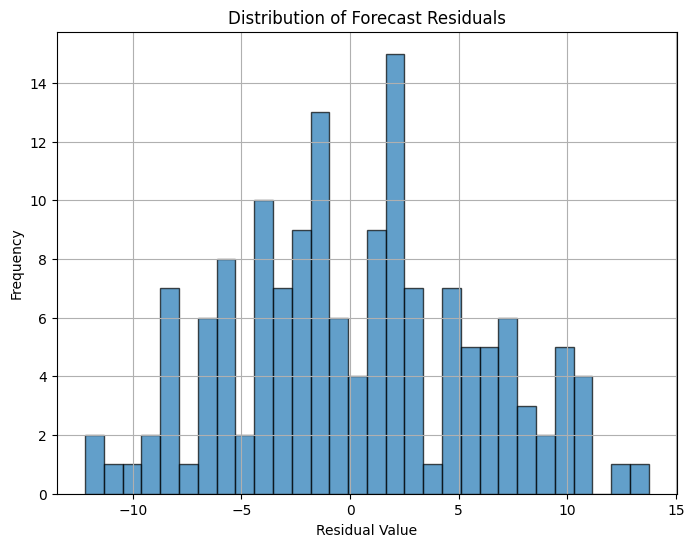

In [9]:
# Define the size of the training and testing sets
train_size = int(len(series) * 0.7) # 70% for initial training
train, test = series[0:train_size], series[train_size:]

print(f"Total data points: {len(series)}")
print(f"Initial training set size: {len(train)}")
print(f"Test set size: {len(test)}")

# Store predictions and actual values
history = [x for x in train] # Initial training data
predictions = list()
actual_values = list()
rmse_scores = list()

# Walk-forward validation loop
print("\nStarting Walk-Forward Validation...")
for t in range(len(test)):
    # Define the ARIMA model
    # order=(p,d,q) as determined in the previous step
    model = ARIMA(history, order=(p,d,q))

    # Fit the model
    model_fit = model.fit()

    # Make one-step-ahead prediction
    yhat = model_fit.forecast()[0] # forecast() returns a Series, we need the first element

    # Store prediction and actual value
    predictions.append(yhat)
    actual = test.iloc[t]
    actual_values.append(actual)

    # Add the actual observed value to the history for the next iteration
    history.append(actual)

    # Calculate and print RMSE for the current step (optional, can be noisy)
    # current_rmse = sqrt(mean_squared_error([actual], [yhat]))
    # print(f'Step {t+1}: Predicted={yhat:.2f}, Expected={actual:.2f}, RMSE={current_rmse:.2f}')

print("\nWalk-Forward Validation Complete.")

# Calculate final RMSE
rmse = sqrt(mean_squared_error(actual_values, predictions))
print(f'Final Test RMSE: {rmse:.3f}')

# Plot actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(series.index[train_size:], actual_values, label='Actual Prices', color='blue')
plt.plot(series.index[train_size:], predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('ARIMA Walk-Forward Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot the residuals (errors)
residuals = np.array(actual_values) - np.array(predictions)
plt.figure(figsize=(12, 5))
plt.plot(series.index[train_size:], residuals, color='purple')
plt.title('Forecast Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()

# Distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Forecast Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()